## Introduction

### Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from IPython import display
from skimage.transform import resize
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

### Go to data folder

In [ ]:
# Connect to Colab
from google.colab import drive
drive.mount('/content/drive/')

# Go to data folder
%cd /content/drive/MyDrive/Projet_A3S5/Donnees/Final_Data

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1VyeGE8G8NemjPGnlHQA2fEjmVxwDsQTS/Projet_A3S5/Donnees/Final_Data


### Utils

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

def convert(y):
    y_ = torch.zeros((len(y),2))
    y_[y==0,0] = 1
    y_[y==1,1] = 1
    return y_

def simp(tensor):
    return torch.squeeze(tensor).cpu().detach().numpy()

## Data processing

In [ ]:
# Retrieve metadata
metadata = os.path.join('Tibia', 'Metadata.xlsx')
df = pd.read_excel(metadata)
df

,Name,Orientation_pca,Orientation_manual,Label,From_Stanford
0,Tibia_01,0,D,1,0
1,Tibia_02,0,D,1,0
2,Tibia_03,0,G,1,0
3,Tibia_04,0,G,1,0
4,Tibia_06,0,D,1,0
...,...,...,...,...,...
188,TIbia_PHC_243,1,NaN,0,1
189,Tibia_PHC_244,1,NaN,0,1
190,Tibia_PHC_245,1,G,1,1
191,Tibia_PHC_248,0,G,0,1


In [ ]:
# Paths to images
path_affine = os.path.join('Tibia','Mirror')
paths = np.array([os.path.join(path_affine, name + '.tiff') for name in df['Name']])

# Load images
images = []
for path in tqdm(paths):
    # img_array = img_array.astype('float32')
    # img_array = resize(img_array[:,:],(150,150), mode='reflect', anti_aliasing=True)
    images.append(imread(path, as_gray = True))
images = np.array(images)

# Retrieve labels
labels = df['Label'].to_numpy()

100%|██████████| 193/193 [00:58<00:00,  3.29it/s]


In [ ]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.30, random_state=42)

## Define Datasets

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        if root == "Train":
            self.imgs = images_train
            self.labels = labels_train
        else:
            self.imgs = images_test
            self.labels = labels_test
        
    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

    def __len__(self):
        return len(self.imgs)

In [ ]:
# Datasets
train_data = MyDataset("Train")
test_data = MyDataset("Test")

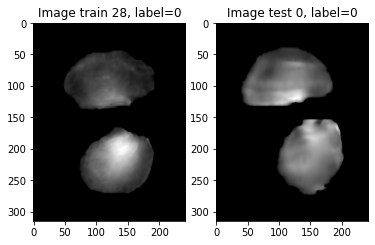

In [ ]:
# Plot a random from datasets
plt.subplot(121)
idx1 = np.random.randint(len(train_data))
img1, lab1 = train_data[idx1]
plt.imshow(img1, cmap='gray')
plt.title(f"Image train {idx1}, label={lab1}")

plt.subplot(122)
idx2 = np.random.randint(len(test_data))
img2, lab2 = test_data[idx2]
plt.imshow(img2, cmap='gray')
plt.title(f"Image test {idx2}, label={lab2}")

plt.show()

In [ ]:
# Dataloaders
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Define Model

In [ ]:
# We define the neural network
class CNN(nn.Module):
    def __init__(self): 
        super(CNN,self).__init__()
        self.layers = nn.Sequential(  #242x315
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),       #298x298  #240x313

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0), #296x296  #238x311
            nn.ReLU(),
            nn.MaxPool2d(2,2),   #148  #119x155

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0), #146 #117x153
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=0), #144 #115x151
            nn.ReLU(),
            nn.MaxPool2d(2,2),  #72  #57x75

            nn.Flatten(),
            nn.Linear (57*75*96,500),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear (500,2),
        )
        
      
    def forward(self,x): 
      return self.layers(x)

cnn_1 = CNN()

In [ ]:
# We define the neural network
class CNN(nn.Module):
    def __init__(self): 
        super(CNN,self).__init__()
        self.layers = nn.Sequential(  
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),      

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0), #296x296  #238x311
            nn.ReLU(),
            nn.MaxPool2d(2,2),  

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0), #146 #117x153
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1, padding=0), #144 #115x151
            nn.ReLU(),
            nn.MaxPool2d(2,2), 

            nn.Flatten(),
            nn.Linear (57*75*96,500),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear (500,2),
        )
        
      
    def forward(self,x): 
      return self.layers(x)

cnn_1 = CNN()

In [ ]:
# GPU or CPU device
device = get_device()
print("Device:", device)
cnn_1.to(device)
summary(cnn_1, (1,242,315))

Device: cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 240, 313]             160
              ReLU-2         [-1, 16, 240, 313]               0
            Conv2d-3         [-1, 32, 238, 311]           4,640
              ReLU-4         [-1, 32, 238, 311]               0
         MaxPool2d-5         [-1, 32, 119, 155]               0
            Conv2d-6         [-1, 64, 117, 153]          18,496
              ReLU-7         [-1, 64, 117, 153]               0
            Conv2d-8         [-1, 96, 115, 151]          55,392
              ReLU-9         [-1, 96, 115, 151]               0
        MaxPool2d-10           [-1, 96, 57, 75]               0
          Flatten-11               [-1, 410400]               0
           Linear-12                  [-1, 500]     205,200,500
             ReLU-13                  [-1, 500]               0
          Dropout-14    

## Training

### Loss & Optimizer

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(cnn_1.parameters(), lr = 0.01) 

### Training Process

In [ ]:
loss = []
PATH_MODEL = '.pth'

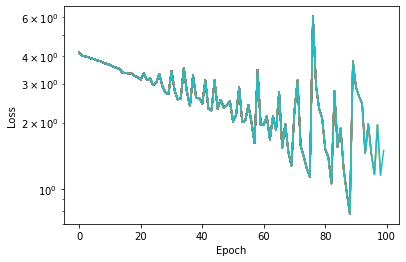

In [ ]:
# Epochs
n_epochs = 100
n_save = 10
n = len(loss)

# Mode train
cnn_1.train()

for epoch in range(n+1, n+n_epochs+1):
    # monitor training loss
    _loss = 0.0

    # Training for each batch
    pbar = tqdm(train_loader, leave=False, position=0)
    for data in pbar:
        pbar.set_description(f"Epoch {epoch}/{n+n_epochs}")

        # Initialize gradients
        optimizer.zero_grad()

        # Retrieve data
        imgs, lbls = data
        imgs = imgs[:,None,:,:].float().to(device)
        lbls = convert(lbls).to(device)

        # Network Inference
        out = cnn_1(imgs)
        L = criterion(out, lbls)

        # Extraction network gradients 
        L.backward()

        optimizer.step()

        _loss += L.item()

    # Update loss
    loss.append(_loss)

    # Plot loss & last outputs
    plt.plot(loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')

    display.clear_output(wait=True)
    display.display(plt.gcf())

    # Save the model
    ...

display.clear_output()

## Testing

In [ ]:
# Mode eval
cnn_1.eval()

y_gt = []
y_pred = []

for data in test_loader:
    # Retrieve data
    imgs, lbls = data
    imgs = imgs[:,None,:,:].float().to(device)
    lbls = convert(lbls).to(device)

    # Network Inference
    out = cnn_1(imgs)

    y_pred.append(simp(out))
    y_gt.append(simp(lbls))

y_pred = np.concatenate(y_pred)
y_gt = np.concatenate(y_gt)

In [ ]:
y_pred_ = y_pred[:,0] > y_pred[:,1]
y_gt_ = y_gt[:,0] > y_gt[:,1]

confusion_matrix(y_gt_, y_pred_)

array([[ 4,  7],
       [ 9, 38]])